In [1]:
%matplotlib inline

import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

In [2]:
# Load data 
data = pd.read_csv('./FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data.head()

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90


In [4]:
data.shape

(77, 4)

In [17]:
data.to_csv(path_or_buf='fifa_data.csv')

In [5]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

In [12]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    
    print('graph:',graph)
    
    club_data = data[data['club'] == club_name]
    
    print('club_data:',club_data)
    
    club_formation = FORMATIONS[formation]
    
    print('club_formation: ',club_formation)
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    print('available_positions: ',available_positions)
    
    available_players = set(zip(club_data['name'], club_data['club_position']))
    print('available_players: ',available_players)
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
        
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

In [13]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [14]:
teams

[('real_madrid', '4-3-3_4'),
 ('chelsea', '5-2-2-1'),
 ('manchester_utd', '4-3-3_2'),
 ('manchester_city', '4-3-3_2'),
 ('juventus', '4-2-3-1_2'),
 ('fc_bayern', '4-2-3-1_2'),
 ('napoli', '4-3-3')]

In [15]:
graph = club2graph('real_madrid', '4-3-3_4', graph)

for team, formation in teams:
    graph = club2graph(team, formation, graph)

graph: 
club_data:                  name         club club_position  rating
0   cristiano_ronaldo  real_madrid            lw      94
7         gareth_bale  real_madrid            rw      90
12        luka_modric  real_madrid            cm      89
16       sergio_ramos  real_madrid            cb      89
23         toni_kroos  real_madrid            cm      88
29               pepe  real_madrid            cb      88
34    james_rodriguez  real_madrid           cam      87
57            marcelo  real_madrid            lb      86
60      karim_benzema  real_madrid            st      86
67       keylor_navas  real_madrid            gk      85
87           carvajal  real_madrid            rb      84
club_formation:  {'gk': ['cb_1', 'cb_2'], 'lb': ['lw', 'cb_1', 'cm_1'], 'cb_1': ['lb', 'cb_2', 'gk'], 'cb_2': ['rb', 'cb_1', 'gk'], 'rb': ['rw', 'cb_2', 'cm_2'], 'cm_1': ['cam', 'lw', 'cb_1', 'lb'], 'cm_2': ['cam', 'rw', 'cb_2', 'rb'], 'cam': ['cm_1', 'cm_2', 'st'], 'lw': ['cm_1', 'lb', 'st'], 'r

In [34]:
from pprint import pprint

In [26]:
graph.number_of_nodes(),graph.number_of_edges(),graph.size(),

(161, 597, 597, dict_values([]))

In [36]:
all_nodes = []
for node in graph.nodes:
    all_nodes.append(node)
    #print(node)
    
print(all_nodes)

['karim_benzema', 'real_madrid', 'st_real_madrid', 'cam_real_madrid', 'james_rodriguez', 'lw_real_madrid', 'cristiano_ronaldo', 'rw_real_madrid', 'gareth_bale', 'cm_2_real_madrid', 'toni_kroos', 'rb_real_madrid', 'carvajal', 'cm_1_real_madrid', 'luka_modric', 'lb_real_madrid', 'marcelo', 'cb_2_real_madrid', 'pepe', 'cb_1_real_madrid', 'sergio_ramos', 'gk_real_madrid', 'keylor_navas', 'pedro', 'chelsea', 'rw_chelsea', 'st_chelsea', 'diego_costa', 'rwb_chelsea', 'victor_moses', 'cm_2_chelsea', "n'golo_kante", 'lw_chelsea', 'eden_hazard', 'cm_1_chelsea', 'nemanja_matic', 'lwb_chelsea', 'marcos_alonso', 'cb_3_chelsea', 'david_luiz', 'cb_2_chelsea', 'azpilicueta', 'cb_1_chelsea', 'gary_cahill', 'gk_chelsea', 'thibaut_courtois', 'zlatan_ibrahimovic', 'manchester_utd', 'st_manchester_utd', 'cm_1_manchester_utd', 'paul_pogba', 'cm_2_manchester_utd', 'ander_herrera', 'lw_manchester_utd', 'anthony_martial', 'rw_manchester_utd', 'henrikh_mkhitaryan', 'michael_carrick', 'cdm_manchester_utd', 'cb_1

In [38]:
all_edges = []
for edge in graph.edges:
    all_edges.append(edge)

print(all_edges)

[('karim_benzema', 'real_madrid'), ('karim_benzema', 'cam_real_madrid'), ('karim_benzema', 'james_rodriguez'), ('karim_benzema', 'lw_real_madrid'), ('karim_benzema', 'cristiano_ronaldo'), ('karim_benzema', 'rw_real_madrid'), ('karim_benzema', 'gareth_bale'), ('real_madrid', 'gareth_bale'), ('real_madrid', 'cristiano_ronaldo'), ('real_madrid', 'james_rodriguez'), ('real_madrid', 'toni_kroos'), ('real_madrid', 'luka_modric'), ('real_madrid', 'carvajal'), ('real_madrid', 'pepe'), ('real_madrid', 'sergio_ramos'), ('real_madrid', 'marcelo'), ('real_madrid', 'keylor_navas'), ('st_real_madrid', 'cam_real_madrid'), ('st_real_madrid', 'lw_real_madrid'), ('st_real_madrid', 'rw_real_madrid'), ('st_real_madrid', 'gareth_bale'), ('st_real_madrid', 'cristiano_ronaldo'), ('st_real_madrid', 'james_rodriguez'), ('cam_real_madrid', 'cm_1_real_madrid'), ('cam_real_madrid', 'cm_2_real_madrid'), ('cam_real_madrid', 'toni_kroos'), ('cam_real_madrid', 'luka_modric'), ('james_rodriguez', 'cm_1_real_madrid'), 

In [39]:
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

Computing transition probabilities: 100%|██████████| 161/161 [00:00<00:00, 4076.88it/s]


In [41]:
len(node2vec.walks)

16100

In [49]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

In [50]:
reformatted_walks[0:1]

[['de_gea',
  'cb',
  'eric_bailly',
  'chris_smalling',
  'cb',
  'michael_carrick',
  'ander_herrera',
  'michael_carrick',
  'manchester_utd',
  'michael_carrick',
  'paul_pogba',
  'st',
  'cm',
  'cdm',
  'chris_smalling',
  'manchester_utd']]

In [51]:
model = node2vec.fit(window=10, min_count=1,ver)

In [80]:
model.vocabulary.raw_vocab,model.workers


(defaultdict(int, {}), 2)

#### Find Similar Nodes

In [78]:
for node, _ in model.most_similar('john_stones'):
    # Show only players
    if len(node) > 3:
        print(node,_)

willy_caballero 0.9514381289482117
yaya_toure 0.948427677154541
nicolas_otamendi 0.9372456073760986
bacary_sagna 0.9282606840133667
manchester_city 0.8929667472839355
gael_clichy 0.8681881427764893
kevin_de_bruyne 0.8189698457717896
raheem_sterling 0.7602306604385376
david_silva 0.7549924850463867
sergio_aguero 0.740198016166687


In [81]:
for node, _ in model.most_similar('gk'):
    # Show only players
    if len(node) > 3:
        print(node)

keylor_navas
de_gea
thibaut_courtois
david_luiz
gary_cahill
manuel_neuer
willy_caballero


In [85]:
model.wv.vocab

{'de_gea': <gensim.models.keyedvectors.Vocab at 0x7f11a12297b8>,
 'cb': <gensim.models.keyedvectors.Vocab at 0x7f11a12292e8>,
 'eric_bailly': <gensim.models.keyedvectors.Vocab at 0x7f11a1229198>,
 'chris_smalling': <gensim.models.keyedvectors.Vocab at 0x7f11a12299e8>,
 'michael_carrick': <gensim.models.keyedvectors.Vocab at 0x7f11a1229d68>,
 'ander_herrera': <gensim.models.keyedvectors.Vocab at 0x7f11a12296d8>,
 'manchester_utd': <gensim.models.keyedvectors.Vocab at 0x7f11a1229ba8>,
 'paul_pogba': <gensim.models.keyedvectors.Vocab at 0x7f11a1229588>,
 'st': <gensim.models.keyedvectors.Vocab at 0x7f11a1229898>,
 'cm': <gensim.models.keyedvectors.Vocab at 0x7f11a1229780>,
 'cdm': <gensim.models.keyedvectors.Vocab at 0x7f11a1229748>,
 'cristiano_ronaldo': <gensim.models.keyedvectors.Vocab at 0x7f11a12297f0>,
 'karim_benzema': <gensim.models.keyedvectors.Vocab at 0x7f11a1229550>,
 'lw': <gensim.models.keyedvectors.Vocab at 0x7f11a1229cc0>,
 'luka_modric': <gensim.models.keyedvectors.Vocab 

In [84]:
clubs

{'chelsea',
 'fc_bayern',
 'juventus',
 'manchester_city',
 'manchester_utd',
 'napoli',
 'real_madrid'}

In [104]:
player_nodes = [x for x in model.wv.vocab if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [105]:
len(player_nodes)

77

In [93]:
embeddings.shape

(77, 20)

#### Embedding Visulaization

In [94]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
embeddings_2d.shape

(77, 2)

In [90]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

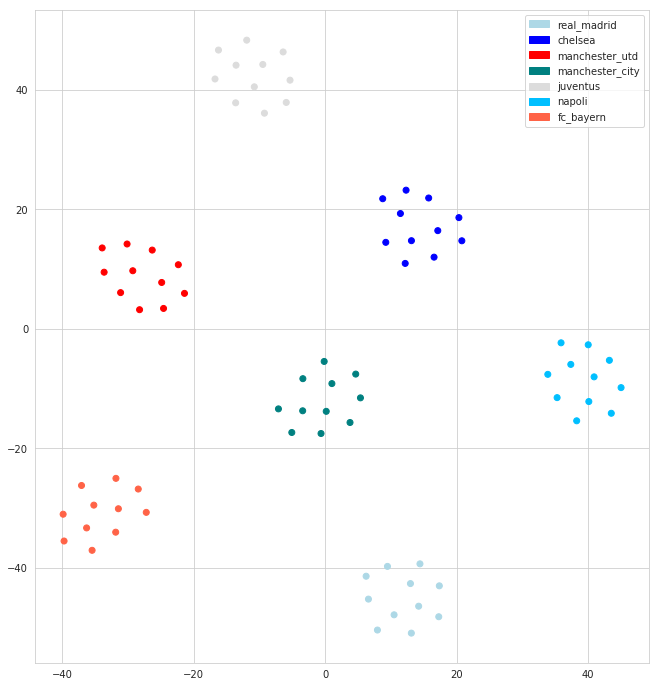

In [97]:
figure = plt.figure(figsize=(11, 12))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);